In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline
import torch
import re
import statsmodels

In [2]:
df = pd.read_csv("/content/imdb_top_1000.csv")

In [3]:
df.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [4]:
def parse_gross(value):
    if pd.isna(value):
        return np.nan
    value = re.sub(r'[^0-9.]', '', str(value))
    try:
        return float(value)
    except:
        return np.nan

In [5]:
df['Gross_Float'] = df['Gross'].apply(parse_gross)

In [6]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
bert_sentiment = pipeline("sentiment-analysis")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [7]:
# VADER
df['vader_score'] = df['Overview'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# TextBlob
df['textblob_polarity'] = df['Overview'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)


In [8]:
df[['Overview','vader_score', 'textblob_polarity']]

,Overview,vader_score,textblob_polarity
0,Two imprisoned men bond over a number of years...,-0.4019,-0.300000
1,An organized crime dynasty's aging patriarch t...,-0.6705,0.000000
2,When the menace known as the Joker wreaks havo...,-0.8176,0.333333
3,The early life and career of Vito Corleone in ...,-0.4767,0.118182
4,A jury holdout attempts to prevent a miscarria...,0.5423,0.000000
...,...,...,...
995,A young New York socialite becomes interested ...,-0.3716,0.067273
996,Sprawling epic covering the life of a Texas ca...,0.0000,0.100000
997,"In Hawaii in 1941, a private is cruelly punish...",-0.4939,-0.166667
998,Several survivors of a torpedoed merchant ship...,-0.5994,0.000000


In [9]:
def get_bert_score(text):
    try:
        result = bert_sentiment(text[:512])[0]
        print(result)
        return result['score'] if result['label'] == 'POSITIVE' else -result['score']
    except:
        return np.nan

df['bert_score'] = df['Overview'].astype(str).apply(get_bert_score)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{'label': 'POSITIVE', 'score': 0.9964224100112915}
{'label': 'POSITIVE', 'score': 0.9875608086585999}
{'label': 'POSITIVE', 'score': 0.9977295994758606}
{'label': 'POSITIVE', 'score': 0.9987801909446716}
{'label': 'NEGATIVE', 'score': 0.9977153539657593}
{'label': 'POSITIVE', 'score': 0.9975845813751221}
{'label': 'POSITIVE', 'score': 0.9959241151809692}
{'label': 'POSITIVE', 'score': 0.9955828785896301}
{'label': 'NEGATIVE', 'score': 0.8724516034126282}
{'label': 'POSITIVE', 'score': 0.9970230460166931}
{'label': 'POSITIVE', 'score': 0.9905771017074585}
{'label': 'POSITIVE', 'score': 0.9952294826507568}
{'label': 'NEGATIVE', 'score': 0.9903538227081299}
{'label': 'POSITIVE', 'score': 0.9904658794403076}
{'label': 'POSITIVE', 'score': 0.7890068292617798}
{'label': 'POSITIVE', 'score': 0.9965552091598511}
{'label': 'POSITIVE', 'score': 0.9681228399276733}
{'label': 'NEGATIVE', 'score': 0.8756753206253052}
{'label': 'POSITIVE', 'score': 0.999836802482605}
{'label': 'NEGATIVE', 'score': 0

In [10]:
# Explore Correlation with IMDB Rating & Box Office Gross
df['Gross_Float'] = pd.to_numeric(df['Gross_Float'], errors='coerce')

#  Correlations
corr_vader_rating = df['vader_score'].corr(df['IMDB_Rating'])
corr_vader_gross  = df['vader_score'].corr(df['Gross_Float'])

corr_tb_rating    = df['textblob_polarity'].corr(df['IMDB_Rating'])
corr_tb_gross     = df['textblob_polarity'].corr(df['Gross_Float'])

corr_bert_rating  = df['bert_score'].corr(df['IMDB_Rating'])
corr_bert_gross   = df['bert_score'].corr(df['Gross_Float'])

print("## CORRELATION RESULTS ##")
print(f"VADER, Rating: {corr_vader_rating:.3f} | Gross: {corr_vader_gross:.3f}")
print(f"TextBlob, Rating: {corr_tb_rating:.3f} | Gross: {corr_tb_gross:.3f}")
print(f"BERT, Rating: {corr_bert_rating:.3f} | Gross: {corr_bert_gross:.3f}")

## CORRELATION RESULTS ##
VADER, Rating: -0.070 | Gross: -0.031
TextBlob, Rating: -0.055 | Gross: 0.021
BERT, Rating: 0.061 | Gross: 0.055


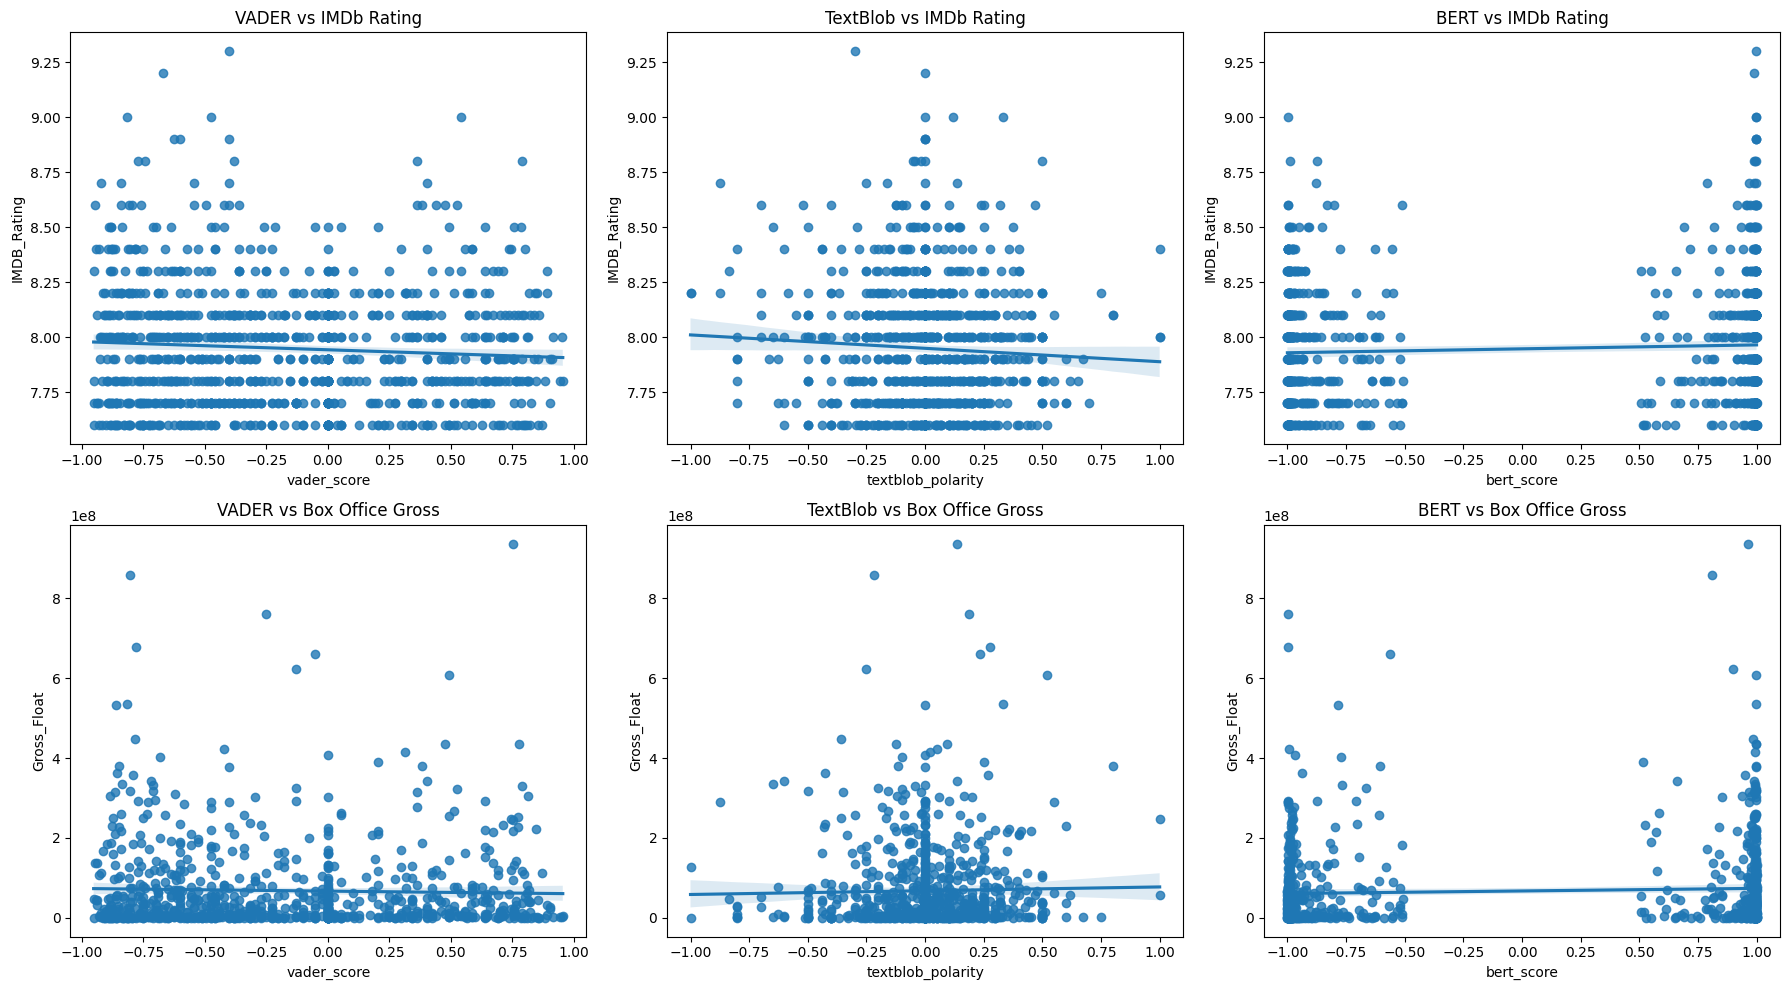

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
methods = ['vader_score', 'textblob_polarity', 'bert_score']
titles = ['VADER', 'TextBlob', 'BERT']

for i, method in enumerate(methods):
    sns.regplot(x=df[method], y=df['IMDB_Rating'], ax=axes[0, i])
    axes[0, i].set_title(f'{titles[i]} vs IMDb Rating')
    sns.regplot(x=df[method], y=df['Gross_Float'], ax=axes[1, i])
    axes[1, i].set_title(f'{titles[i]} vs Box Office Gross')

plt.tight_layout()
plt.show()


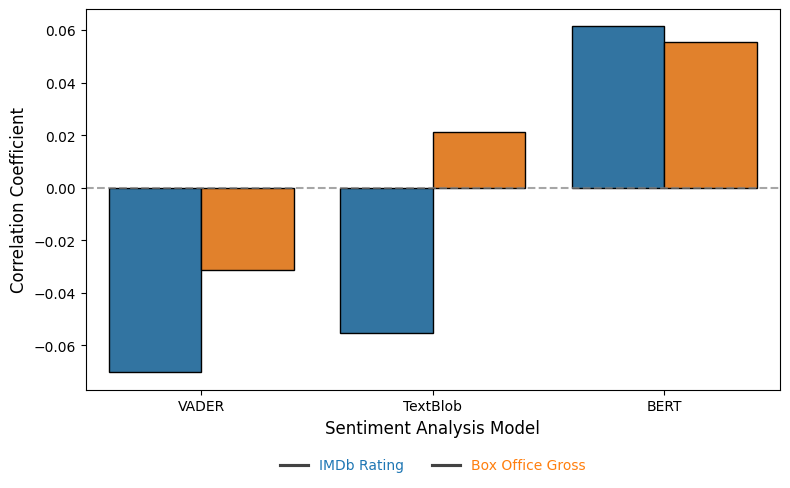

In [12]:
results = pd.DataFrame({
    'Model': ['VADER', 'TextBlob', 'BERT'],
    'Corr_with_IMDB_Rating': [corr_vader_rating, corr_tb_rating, corr_bert_rating],
    'Corr_with_Gross': [corr_vader_gross, corr_tb_gross,corr_bert_gross]
})


results_melted = results.melt(
    id_vars='Model',
    var_name='Correlation_Type',
    value_name='Correlation'
)

palette = ['#1F77B4', '#FF7F0E']  # Blue & Orange

plt.figure(figsize=(8,5))
sns.barplot(
    data=results_melted,
    x='Model',
    y='Correlation',
    hue='Correlation_Type',
    palette=palette,
    edgecolor='black'
)

# plt.title("Sentiment Correlation Comparison", fontsize=15, weight='bold', pad=15)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xlabel("Sentiment Analysis Model", fontsize=12)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)

legend = plt.legend(
    labels=["IMDb Rating", "Box Office Gross"],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    frameon=False
)

legend.get_texts()[0].set_color('#1F77B4')  # IMDb Rating
legend.get_texts()[1].set_color('#FF7F0E')  # for Box Office Gross

plt.tight_layout()
plt.show()
